In [28]:
# Loading important libraries

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys
import sklearn.preprocessing as prepro
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
import sklearn.tree as tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
import xgboost as xgb

SEED = 50661
DATA_IMPUTE = "median"

In [29]:
# Initializing train/test/val file locations

trainFile = "COL774_mammography/train.csv"
testFile = "COL774_mammography/test.csv"
valFile = "COL774_mammography/val.csv"

In [30]:
# preprocess data

def returnAgg(vector):
    if DATA_IMPUTE=="mean":
        return np.mean(vector)
    return np.median(vector)

def returnData(filename):
    df = pd.read_csv(filename)
    
    if DATA_IMPUTE!=None:
        
        ageRep = returnAgg(np.array(df[df.Age!='?']["Age"],dtype=float))
        shapeRep = returnAgg(np.array(df[df.Shape!='?']["Shape"],dtype=float))
        marginRep = returnAgg(np.array(df[df.Margin!='?']["Margin"],dtype=float))
        densityRep = returnAgg(np.array(df[df.Density!='?']["Density"],dtype=float))
        
        df.Age.replace('?',str(ageRep),inplace = True)
        df.Shape.replace('?',str(shapeRep),inplace = True)
        df.Margin.replace('?',str(marginRep),inplace = True)
        df.Density.replace('?',str(densityRep),inplace = True)
    
    df.dropna()
    df = df[(df.Age!='?') & (df.Shape!='?') & (df.Margin!='?') & (df.Density!='?')]
    
    X = np.array([df["Age"],df["Shape"],df["Margin"],df["Density"]],dtype = float).T
    Y = np.array(df["Severity"],dtype = float)
    
    #X = prepro.normalize(X)
    
    return X,Y

X_train,Y_train = returnData(trainFile)
X_test,Y_test = returnData(testFile)
X_val,Y_val = returnData(valFile)

Training accuracy : 0.9180633147113594
Testing accuracy : 0.7326388888888888
Validation accuracy : 0.7407407407407407


<Figure size 640x480 with 0 Axes>

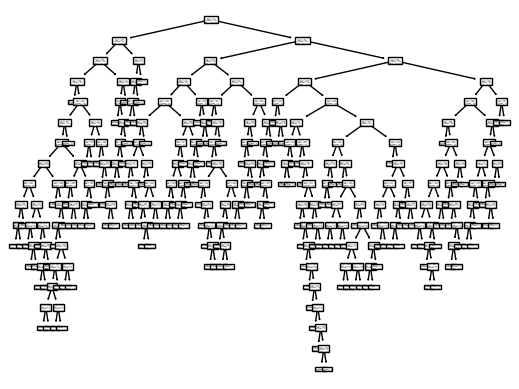

<Figure size 640x480 with 0 Axes>

In [31]:
# 1.a

def printAccuracies(clf):
    
    Y_train_pred = clf.predict(X_train)
    print("Training accuracy : "+str(accuracy_score(Y_train,Y_train_pred)))

    Y_test_pred = clf.predict(X_test)
    print("Testing accuracy : "+str(accuracy_score(Y_test,Y_test_pred)))

    Y_val_pred = clf.predict(X_val)
    print("Validation accuracy : "+str(accuracy_score(Y_val,Y_val_pred)))

    
clf = DecisionTreeClassifier(random_state = SEED)
clf.fit(X_train,Y_train)
printAccuracies(clf)
tree.plot_tree(clf)
plt.savefig("1.1.a.png")
plt.figure()

Optimal parameters obtained are : {'criterion': 'gini', 'max_depth': 4, 'min_samples_leaf': 3, 'min_samples_split': 2}
Training accuracy : 0.8156424581005587
Testing accuracy : 0.8090277777777778
Validation accuracy : 0.8740740740740741


<Figure size 640x480 with 0 Axes>

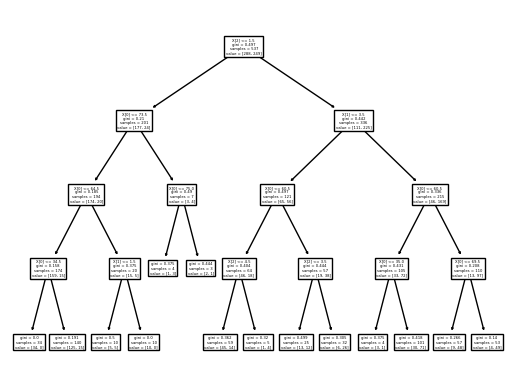

<Figure size 640x480 with 0 Axes>

In [32]:
# 1.b

def doGridSearch(ourEstimator,ourParamGrid):
    grid_search = GridSearchCV(estimator = ourEstimator,param_grid = ourParamGrid)
    grid_search.fit(X_train,Y_train)

    clf = grid_search.best_estimator_
    print("Optimal parameters obtained are : "+str(grid_search.best_params_))
    printAccuracies(clf)
    
    return clf

param_grid = {'criterion' :['gini', 'entropy'],
             'max_depth' : range(1,11),
             'min_samples_split': range(2,11),
             'min_samples_leaf': range(1,11)}

clf = doGridSearch(DecisionTreeClassifier(random_state = SEED),param_grid)
tree.plot_tree(clf)
plt.savefig("1.1.b.png")
plt.figure()

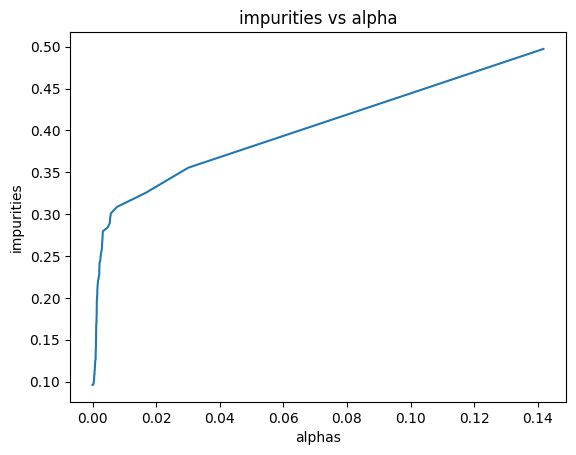

<Figure size 640x480 with 0 Axes>

In [33]:
#1.c 

def plotGraph(pruneDict,values,name):
    plt.plot(pruneDict['ccp_alphas'],values)
    plt.xlabel('alphas')
    plt.ylabel(name)
    plt.title(name+' vs alpha')
    plt.savefig('1.1.c.'+name+'.png')
    plt.figure()

clf = DecisionTreeClassifier(random_state = SEED)
pruneDict = clf.cost_complexity_pruning_path(X = X_train,y = Y_train)

plotGraph(pruneDict,pruneDict['impurities'],'impurities')

Training accuracy : 0.8026070763500931
Testing accuracy : 0.7916666666666666
Validation accuracy : 0.8740740740740741


<Figure size 640x480 with 0 Axes>

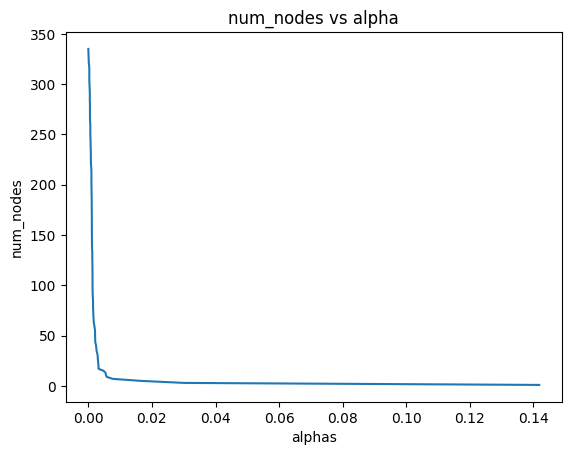

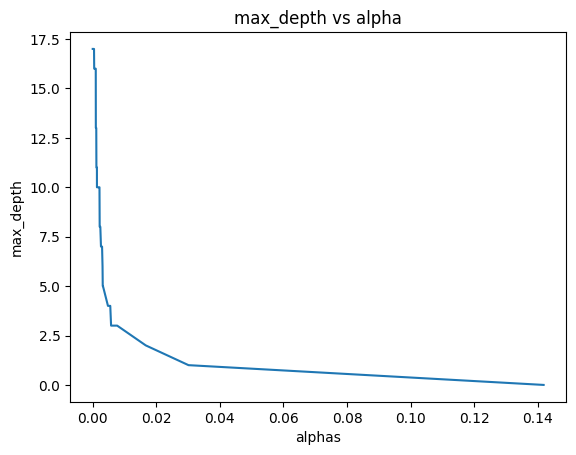

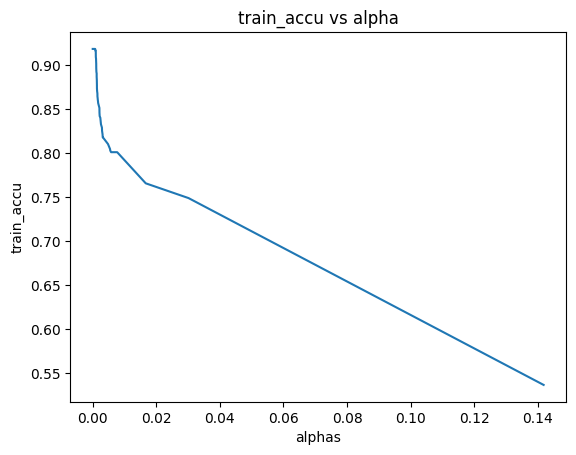

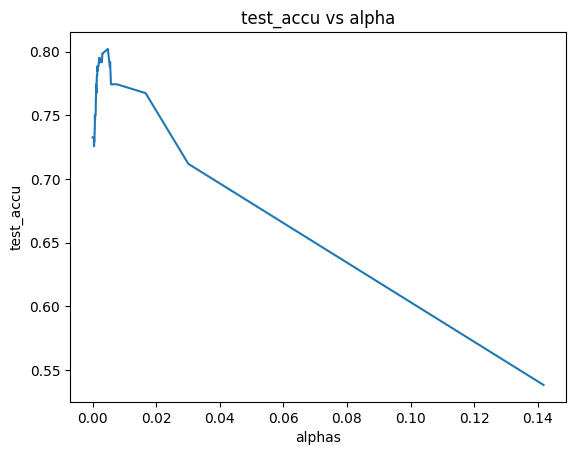

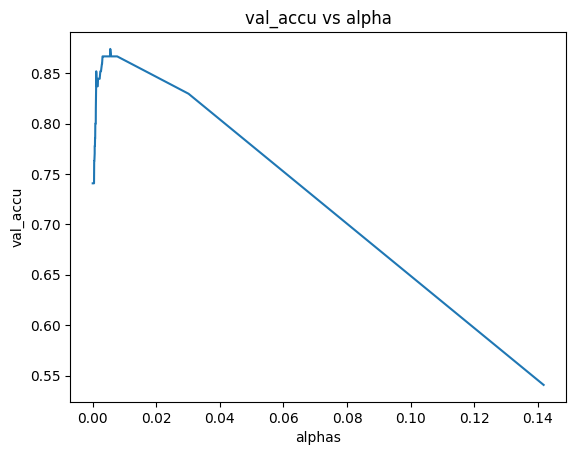

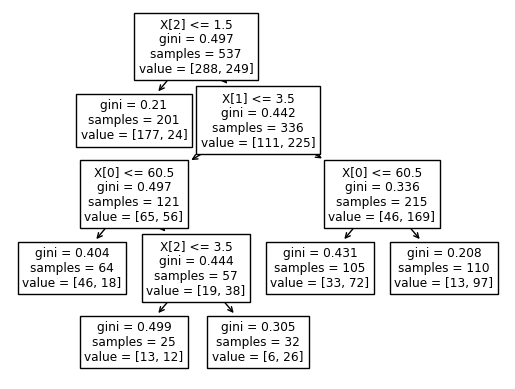

<Figure size 640x480 with 0 Axes>

In [34]:
numNodesList = []
depthList = []
trainList = []
testList = []
valList = []

best_clf = None
best_val_acc = -1

for thisAlpha in pruneDict["ccp_alphas"]:
    clf = DecisionTreeClassifier(ccp_alpha = thisAlpha,random_state = SEED)
    clf.fit(X_train,Y_train)
    
    numNodesList.append(clf.tree_.node_count)
    depthList.append(clf.tree_.max_depth)
    
    Y_train_pred = clf.predict(X_train)
    trainList.append(accuracy_score(Y_train,Y_train_pred))

    Y_test_pred = clf.predict(X_test)
    testList.append(accuracy_score(Y_test,Y_test_pred))

    Y_val_pred = clf.predict(X_val)
    valList.append(accuracy_score(Y_val,Y_val_pred))
    
    if accuracy_score(Y_val,Y_val_pred)>best_val_acc:
        best_val_acc = accuracy_score(Y_val,Y_val_pred)
        best_clf = clf

plotGraph(pruneDict,numNodesList,'num_nodes')
plotGraph(pruneDict,depthList,'max_depth')
plotGraph(pruneDict,trainList,'train_accu')
plotGraph(pruneDict,testList,'test_accu')
plotGraph(pruneDict,valList,'val_accu')

#print(best_val_acc)
printAccuracies(best_clf)
tree.plot_tree(best_clf)
plt.savefig("1.1.c.png")
plt.figure()

In [35]:
# 1.d

param_grid = {'criterion' :['gini', 'entropy'],
              'n_estimators' : [50,100,150,200],
              'max_features' : ["sqrt", "log2", None],
              'min_samples_split': [2,4,6,8,10]}

best_clf = doGridSearch(RandomForestClassifier(random_state = SEED,oob_score = True),param_grid)
print('OOB score : '+str(best_clf.oob_score_))

Optimal parameters obtained are : {'criterion': 'entropy', 'max_features': 'sqrt', 'min_samples_split': 10, 'n_estimators': 50}
Training accuracy : 0.8566108007448789
Testing accuracy : 0.78125
Validation accuracy : 0.8518518518518519
OOB score : 0.7541899441340782


In [18]:
# 1.f
param_grid = {'n_estimators' : [10,20,30,40,50],
              'subsample' : [0.1,0.2,0.3,0.4,0.5],
              'max_depth' : [4,5,6,7,8,9,10]}

clf = doGridSearch(xgb.XGBClassifier(),param_grid)

Optimal parameters obtained are : {'max_depth': 5, 'n_estimators': 10, 'subsample': 0.4}
Training accuracy : 0.8289473684210527
Testing accuracy : 0.7628458498023716
Validation accuracy : 0.8842975206611571
